### Linear regression: loss landscape and gradient descent walkthrough

This notebook builds a simple linear regression from scratch (single‑neuron linear unit with identity activation), visualizes the mean squared error (MSE) loss landscape over weight (w) and bias (b), and shows how gradient descent traverses that landscape.

We proceed in small, focused steps:
- Model and objective: single‑neuron hypothesis $\hat y = w x + b$ and MSE loss
- Data generation and baseline fit via SciPy’s `linregress`
- Loss landscape construction and visualization; remarks on how data statistics shape the contours
- Gradient descent with tracking; visualize the first 10 steps and the evolving regression lines
- OLS optimum: definition and closed‑form computation, compared with `linregress`
- Interactive exploration with controls (data, landscape bounds, resolution, learning rate, steps, path rendering)
- Compact table for the first 10 iterations


### Model: single‑neuron linear unit
We use a single neuron with identity activation (no nonlinearity):

- Hypothesis: $\hat{y} = w x + b$
- Parameters: $w$ (weight), $b$ (bias)
- Loss (MSE): $$J(w,b) = \frac{1}{n} \sum_{i=1}^{n} (y_i - (w x_i + b))^2$$

This is ordinary least squares with one feature and an intercept. The landscape we visualize is this loss as a function of $(w,b)$ for the fixed dataset generated above.


#### Activation function remark
We use an identity activation (no nonlinearity), so the neuron computes $\hat{y} = w x + b$ directly.

- If we introduced a nonlinearity, e.g., $\hat{y} = \text{ReLU}(w x + b)$, the MSE landscape would become piecewise‑quadratic and generally non‑convex. The contours would show kinks where $w x + b = 0$, and gradient descent behavior could change significantly.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

np.random.seed(0)  # Ensuring reproducibility


### Generate synthetic data and visualize it
We create a simple linear relationship with noise: y = 3x + 4 + ε. Then we scatter-plot the data.


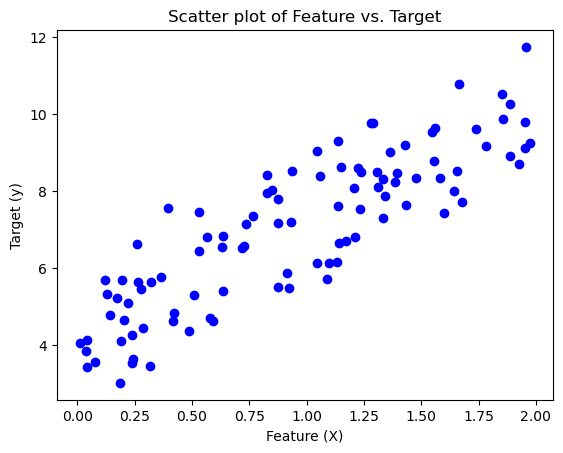

In [2]:
# Generate some data that roughly follows a linear pattern
X = 2 * np.random.rand(100)  # 100 random data points from 0 to 2
y = 3 * X + 4 + np.random.randn(100)  # y = 3X + 4 + noise

# Visualize the data
plt.scatter(X, y, color='blue')
plt.xlabel('Feature (X)')
plt.ylabel('Target (y)')
plt.title('Scatter plot of Feature vs. Target')
plt.show()


### Baseline fit with SciPy
Use `stats.linregress` to estimate slope and intercept and plot the fitted line.


Slope (m): 2.968467510701019
Intercept (b): 4.222151077447231


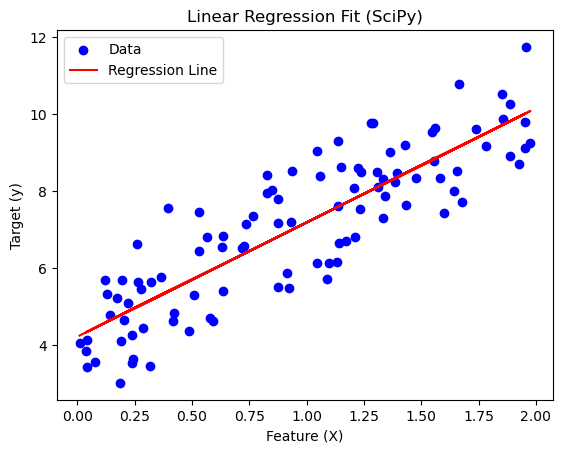

In [3]:
slope, intercept, r_value, p_value, std_err = stats.linregress(X.flatten(), y)
print(f"Slope (m): {slope}")
print(f"Intercept (b): {intercept}")

# Predict and plot regression line
y_pred = slope * X + intercept
plt.scatter(X, y, color='blue', label='Data')
plt.plot(X, y_pred, color='red', label='Regression Line')
plt.xlabel('Feature (X)')
plt.ylabel('Target (y)')
plt.title('Linear Regression Fit (SciPy)')
plt.legend()
plt.show()


### Prepare for loss landscape
- Reshape `X` and `y` to column vectors
- Define ranges for weight `w` and bias `b`
- Build a grid over (w, b)


In [4]:
# Reshape for computations
X = X.reshape(-1, 1)
y = y.reshape(-1, 1)

# Define grid
w_values = np.linspace(0, 6, 400)
b_values = np.linspace(0, 8, 400)
W, B = np.meshgrid(w_values, b_values)


### Compute MSE loss over the (w, b) grid
For each grid point, compute `Loss = mean((y - (wX + b))^2)`.


In [5]:
# Vectorized loss evaluation over the (w, b) grid
x_vals = X[:, 0][:, None, None]
y_vals = y[:, 0][:, None, None]
Loss = np.mean((y_vals - (W[None, :, :] * x_vals + B[None, :, :])) ** 2, axis=0)


### Visualize the loss landscape
Use a filled contour plot to show the MSE surface across weight and bias.


### How the loss landscape reflects the data distribution
The contour shape and orientation come from the data statistics:

- Spread of x (variance of `X`): Wider variance sharpens curvature along the weight axis. If `X` has little spread, many (w, b) pairs fit similarly, flattening the landscape.
- Centering of x (mean of `X`): If `X` is centered near 0, weight and bias are less correlated, making contours more circular. If `X` is far from 0, weight and bias are more coupled, tilting the contours.
- Noise level (variance of residuals): Higher noise raises the overall loss and can make minima broader (shallower curvature).
- Sample size: More data tightens curvature and stabilizes the minimum location.

Mathematically, for MSE the landscape is a convex quadratic in (w, b). Its curvature is governed by moments of the data, notably $\sum x_i^2$, $\sum x_i$, and $n$.

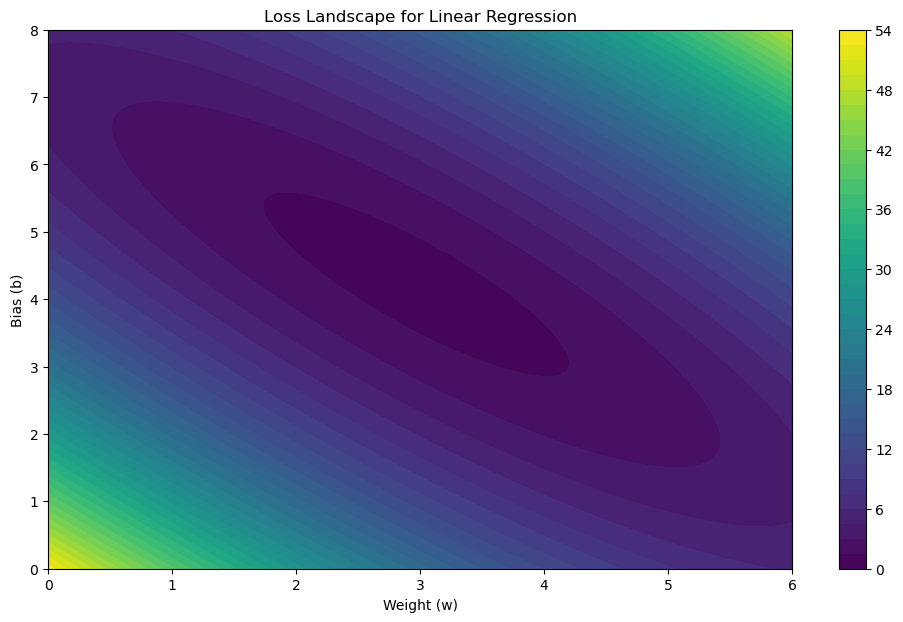

In [6]:
plt.figure(figsize=(12, 7))
contour = plt.contourf(W, B, Loss, 50, cmap='viridis')
plt.colorbar(contour)
plt.title('Loss Landscape for Linear Regression')
plt.xlabel('Weight (w)')
plt.ylabel('Bias (b)')
plt.show()


### Gradient descent with detailed tracking
We initialize `(w, b)`, iterate updates using analytical gradients, and record the first 10 steps for later visualization.


In [7]:
# Initialize parameters and hyperparameters
w = 0.0
b = 0.0
learning_rate = 0.1
n_iterations = 100

# Helper to evaluate MSE for a given parameter pair
def mse_loss(params):
    w_val, b_val = params
    y_pred_val = w_val * X + b_val
    return float(np.mean((y - y_pred_val) ** 2))

history = {
    'iteration': [0],
    'w': [w],
    'b': [b],
    'loss': [mse_loss((w, b))],
    'grad_norm': [np.nan],
}

first_10_history = {'iteration': [], 'w': [], 'b': [], 'dw': [], 'db': [], 'grad_norm': [], 'loss': []}

for iteration in range(1, n_iterations + 1):
    y_pred = w * X + b
    dw = (-2 / len(X)) * np.sum(X * (y - y_pred))
    db = (-2 / len(X)) * np.sum(y - y_pred)
    grad_norm = float(np.sqrt(dw ** 2 + db ** 2))

    w -= learning_rate * dw
    b -= learning_rate * db

    loss = mse_loss((w, b))

    history['iteration'].append(iteration)
    history['w'].append(w)
    history['b'].append(b)
    history['loss'].append(loss)
    history['grad_norm'].append(grad_norm)

    if iteration <= 10:
        first_10_history['iteration'].append(iteration)
        first_10_history['w'].append(w)
        first_10_history['b'].append(b)
        first_10_history['dw'].append(dw)
        first_10_history['db'].append(db)
        first_10_history['grad_norm'].append(grad_norm)
        first_10_history['loss'].append(loss)

    if iteration % 10 == 0 or iteration == 1:
        print(f"Iteration {iteration}: w = {w:.4f}, b = {b:.4f}, loss = {loss:.4f}, ||grad|| = {grad_norm:.4f}")

history_df = pd.DataFrame(history)
first10_df = pd.DataFrame(first_10_history)


Iteration 1: w = 1.5267, b = 1.4058, loss = 19.1529, ||grad|| = 20.7537
Iteration 10: w = 3.5187, b = 3.5654, loss = 1.1117, ||grad|| = 0.3324
Iteration 20: w = 3.3782, b = 3.7602, loss = 1.0538, ||grad|| = 0.2054
Iteration 30: w = 3.2639, b = 3.8892, loss = 1.0243, ||grad|| = 0.1481
Iteration 40: w = 3.1815, b = 3.9821, loss = 1.0090, ||grad|| = 0.1067
Iteration 50: w = 3.1220, b = 4.0491, loss = 1.0011, ||grad|| = 0.0770
Iteration 60: w = 3.0792, b = 4.0974, loss = 0.9969, ||grad|| = 0.0555
Iteration 70: w = 3.0483, b = 4.1322, loss = 0.9948, ||grad|| = 0.0400
Iteration 80: w = 3.0260, b = 4.1573, loss = 0.9936, ||grad|| = 0.0288
Iteration 90: w = 3.0099, b = 4.1754, loss = 0.9931, ||grad|| = 0.0208
Iteration 100: w = 2.9984, b = 4.1884, loss = 0.9928, ||grad|| = 0.0150


### Gradient sanity check

Compare analytical gradients with finite-difference approximations at a few checkpoints to verify the implementation.

In [8]:
def analytical_grad(w_val: float, b_val: float):
    y_pred = w_val * X + b_val
    dw_val = (-2 / len(X)) * np.sum(X * (y - y_pred))
    db_val = (-2 / len(X)) * np.sum(y - y_pred)
    return np.array([dw_val, db_val])


def finite_difference_grad(w_val: float, b_val: float, eps: float = 1e-5):
    w_forward = mse_loss((w_val + eps, b_val))
    w_backward = mse_loss((w_val - eps, b_val))
    b_forward = mse_loss((w_val, b_val + eps))
    b_backward = mse_loss((w_val, b_val - eps))
    dw_fd = (w_forward - w_backward) / (2 * eps)
    db_fd = (b_forward - b_backward) / (2 * eps)
    return np.array([dw_fd, db_fd])

check_points = [
    ('start (iter 0)', history_df.iloc[0]),
    ('after 5 steps', history_df.iloc[5]),
    ('final (iter 100)', history_df.iloc[-1]),
]

rows = []
for label, row in check_points:
    w_val, b_val = row['w'], row['b']
    analytic = analytical_grad(w_val, b_val)
    numeric = finite_difference_grad(w_val, b_val)
    rows.append({
        'point': label,
        'dw_analytic': analytic[0],
        'dw_numeric': numeric[0],
        'db_analytic': analytic[1],
        'db_numeric': numeric[1],
        'grad_diff_norm': np.linalg.norm(analytic - numeric),
    })

grad_check_df = pd.DataFrame(rows)
print('Analytical vs finite-difference gradients:')
print(grad_check_df.to_string(index=False))


Analytical vs finite-difference gradients:
           point  dw_analytic  dw_numeric  db_analytic  db_numeric  grad_diff_norm
  start (iter 0)   -15.267116  -15.267116   -14.058195  -14.058195    7.714910e-10
   after 5 steps    -0.864999   -0.864999    -1.201615   -1.201615    2.158341e-11
final (iter 100)     0.009627    0.009627    -0.010849   -0.010849    1.146509e-11


### Compare optimization routes

Cross-check the parameters recovered by gradient descent against the closed-form solution and SciPy's linear regression.

In [9]:
x_flat = X[:, 0]
y_flat = y[:, 0]
x_mean = x_flat.mean()
y_mean = y_flat.mean()
ols_w = ((x_flat - x_mean) @ (y_flat - y_mean)) / ((x_flat - x_mean) @ (x_flat - x_mean))
ols_b = y_mean - ols_w * x_mean

comparison_df = pd.DataFrame([
    {'method': 'Closed-form OLS', 'w': ols_w, 'b': ols_b, 'loss': mse_loss((ols_w, ols_b))},
    {'method': 'SciPy linregress', 'w': slope, 'b': intercept, 'loss': mse_loss((slope, intercept))},
    {'method': 'Gradient descent', 'w': history_df.iloc[-1]['w'], 'b': history_df.iloc[-1]['b'], 'loss': history_df.iloc[-1]['loss']},
])

comparison_df['Δw vs OLS'] = comparison_df['w'] - ols_w
comparison_df['Δb vs OLS'] = comparison_df['b'] - ols_b
comparison_df['Δloss vs OLS'] = comparison_df['loss'] - comparison_df.loc[0, 'loss']

print('Parameter comparison across solutions:')
print(comparison_df.to_string(index=False, float_format=lambda v: f"{v:.6f}"))


Parameter comparison across solutions:
          method        w        b     loss  Δw vs OLS  Δb vs OLS  Δloss vs OLS
 Closed-form OLS 2.968468 4.222151 0.992439   0.000000   0.000000      0.000000
SciPy linregress 2.968468 4.222151 0.992439   0.000000   0.000000      0.000000
Gradient descent 2.998373 4.188448 0.992765   0.029906  -0.033703      0.000327


### Loss trajectory

Visualize how the loss and gradient norms evolve during gradient descent.

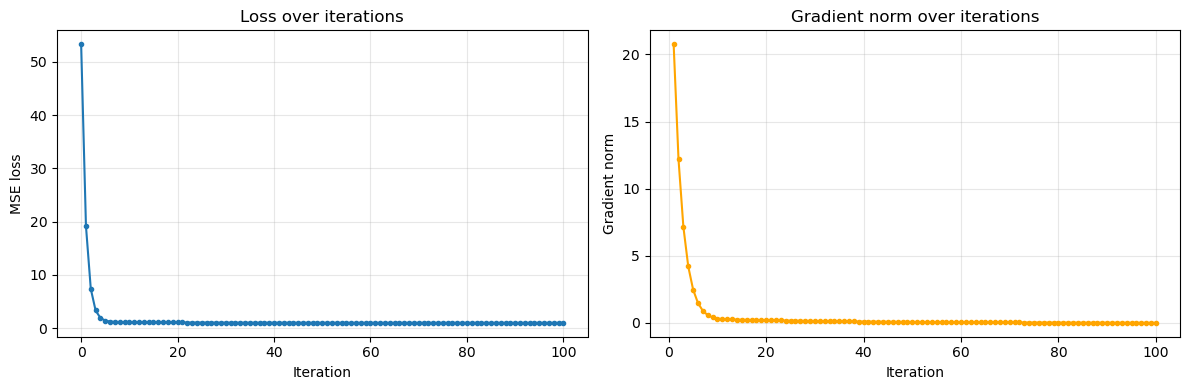

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(history_df['iteration'], history_df['loss'], marker='o', markersize=3)
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('MSE loss')
axes[0].set_title('Loss over iterations')
axes[0].grid(alpha=0.3)

axes[1].plot(history_df['iteration'][1:], history_df['grad_norm'][1:], marker='o', markersize=3, color='orange')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Gradient norm')
axes[1].set_title('Gradient norm over iterations')
axes[1].grid(alpha=0.3)

fig.tight_layout()
plt.show()


### First 10 gradient steps on the loss landscape
Plot the path of the first 10 parameter updates over the contour plot.


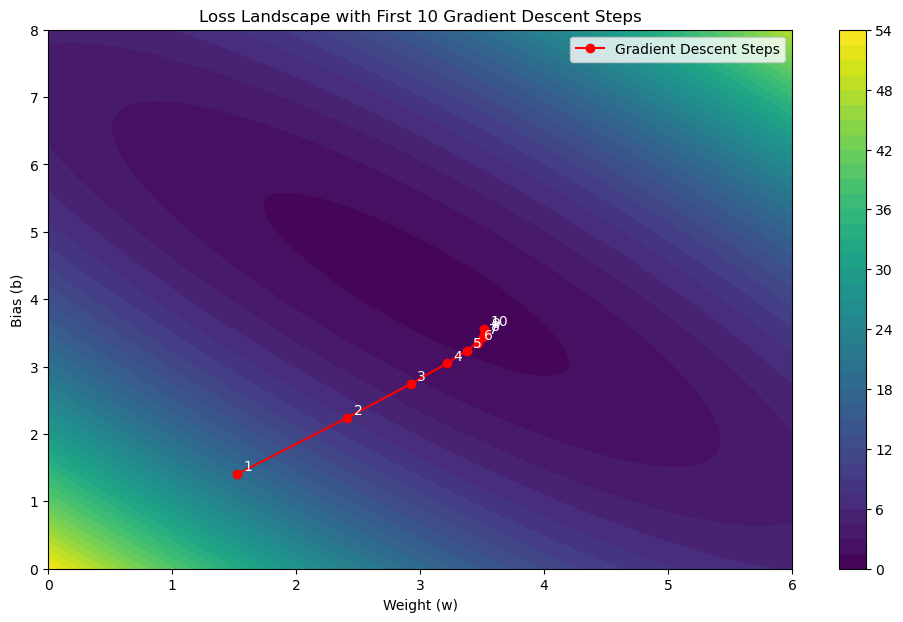

In [11]:
plt.figure(figsize=(12, 7))
contour = plt.contourf(W, B, Loss, 50, cmap='viridis')
plt.colorbar(contour)
plt.title('Loss Landscape with First 10 Gradient Descent Steps')
plt.xlabel('Weight (w)')
plt.ylabel('Bias (b)')

w_first10 = first_10_history['w']
b_first10 = first_10_history['b']
plt.plot(w_first10, b_first10, marker='o', color='red', label='Gradient Descent Steps')

for i in range(len(w_first10)):
    plt.text(w_first10[i] + 0.05, b_first10[i] + 0.05, str(first_10_history['iteration'][i]), color='white')

plt.legend()
plt.show()


### Regression lines across the first 10 iterations
Compare the model’s predictions evolving over the first 10 gradient updates.


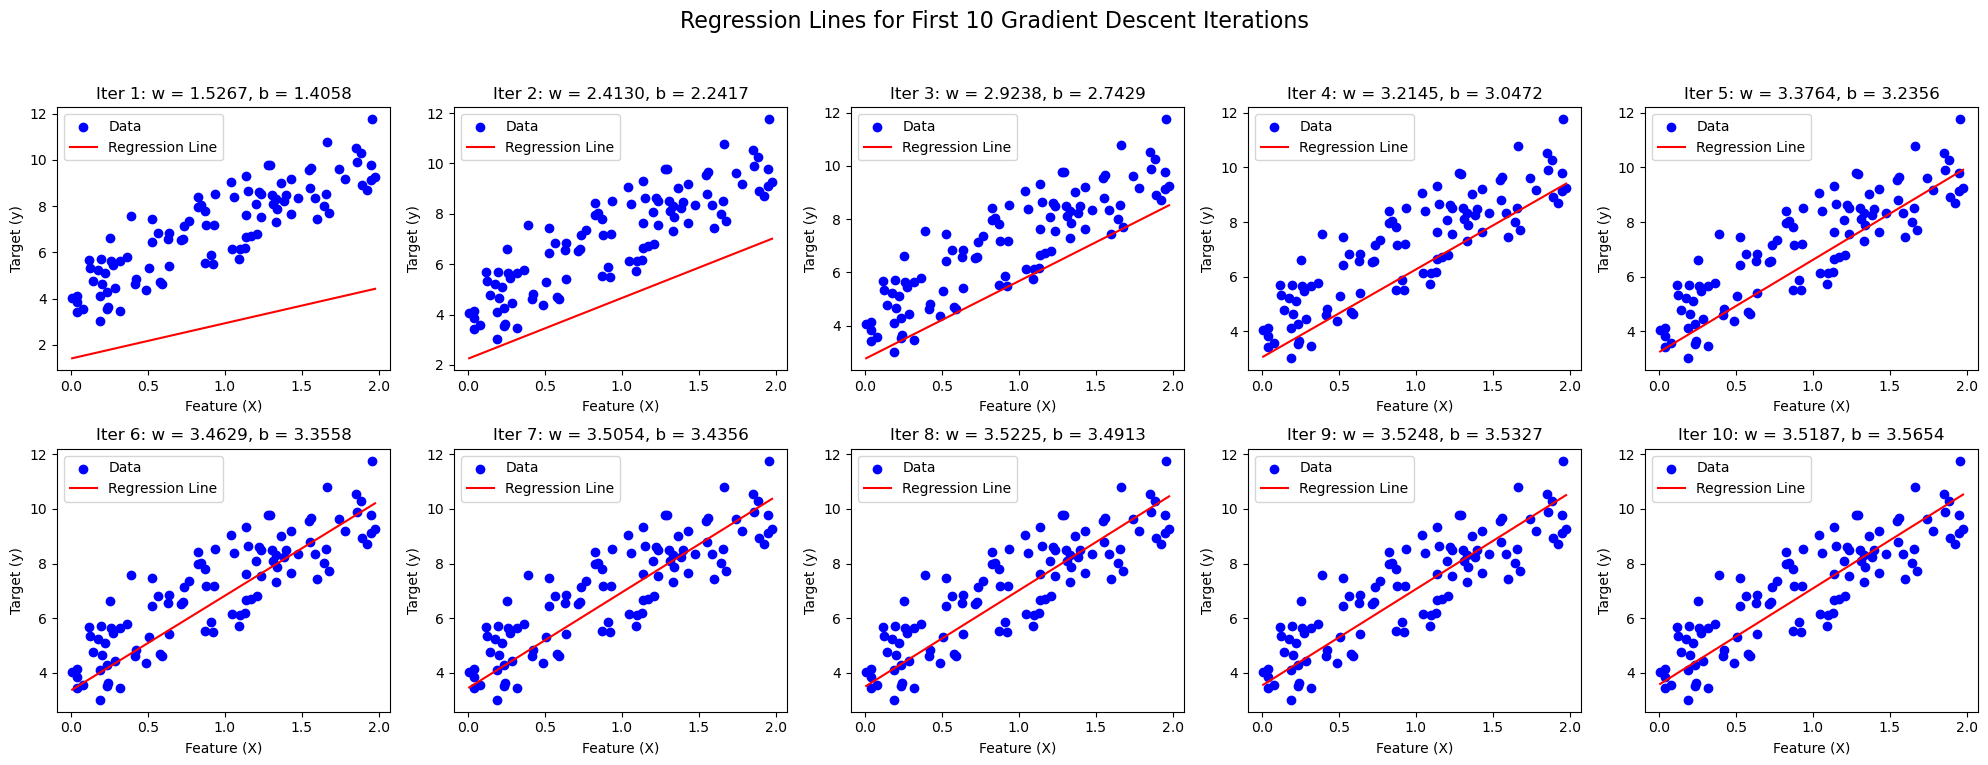

In [12]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i in range(10):
    ax = axes[i]
    iteration = first_10_history['iteration'][i]
    w_iter = first_10_history['w'][i]
    b_iter = first_10_history['b'][i]

    y_pred_iter = w_iter * X + b_iter

    sorted_indices = X[:, 0].argsort()
    X_sorted = X[sorted_indices]
    y_pred_sorted = y_pred_iter[sorted_indices]

    ax.scatter(X, y, color='blue', label='Data')
    ax.plot(X_sorted, y_pred_sorted, color='red', label='Regression Line')
    ax.set_title(f'Iter {iteration}: w = {w_iter:.4f}, b = {b_iter:.4f}')
    ax.set_xlabel('Feature (X)')
    ax.set_ylabel('Target (y)')
    ax.legend()

plt.suptitle('Regression Lines for First 10 Gradient Descent Iterations', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Takeaways
- We trained a single-neuron linear model (OLS) and examined its MSE landscape over (w, b).
- The landscape is convex quadratic; gradient descent converges smoothly with a reasonable learning rate.
- Data statistics (mean/variance of `X`, noise, n) determine the contour orientation and curvature and thus the optimization dynamics.


### First 10 iterations: detailed table
Present the tracked values in a tidy format for easy inspection.


In [13]:
print('\nDetailed information for the first 10 gradient descent iterations:')
print(first10_df.to_string(index=False, float_format=lambda v: f"{v:.6f}"))

print('\nLoss trace for iterations 0-10:')
print(history_df.head(11).to_string(index=False, float_format=lambda v: f"{v:.6f}"))

print('\nFinal iteration summary:')
print(history_df.tail(1).to_string(index=False, float_format=lambda v: f"{v:.6f}"))



Detailed information for the first 10 gradient descent iterations:
 iteration        w        b         dw         db  grad_norm      loss
         1 1.526712 1.405819 -15.267116 -14.058195  20.753739 19.152909
         2 2.413023 2.241747  -8.863114  -8.359276  12.183279  7.373171
         3 2.923815 2.742872  -5.107916  -5.011251   7.155658  3.308070
         4 3.214526 3.047173  -2.907119  -3.043004   4.208470  1.900513
         5 3.376372 3.235634  -1.618455  -1.884616   2.484185  1.408727
         6 3.462872 3.355796  -0.864999  -1.201615   1.480575  1.232790
         7 3.505427 3.435566  -0.425550  -0.797705   0.904116  1.166052
         8 3.522456 3.491335  -0.170293  -0.557685   0.583106  1.137312
         9 3.524761 3.532729  -0.023049  -0.413943   0.414584  1.122025
        10 3.518672 3.565409   0.060890  -0.326795   0.332420  1.111712

Loss trace for iterations 0-10:
 iteration        w        b      loss  grad_norm
         0 0.000000 0.000000 53.330319        NaN
       

### Interactive exploration: data and loss landscape
Use the controls to change data generation parameters and grid ranges. The right plot shows the loss landscape and the gradient descent path.

- Data controls:
  - n: number of data points
  - x_max: range of x values (0 to x_max)
  - true_w, true_b: ground-truth line used to sample y
  - noise: standard deviation of Gaussian noise
- Landscape controls:
  - w_min, w_max, b_min, b_max: axes limits for the loss landscape
  - grid_res: resolution of the loss grid (higher = smoother but slower)
- Optimization controls:
  - lr: learning rate
  - steps: number of gradient descent iterations to run
  - plot_steps: how many earliest iterations to draw; it is clamped to ≤ steps + 1
  - annotate: toggle iteration number labels on the path
  - seed: RNG seed for reproducible resampling (slider + numeric input)

Notes:
- The path color encodes iteration order (earlier → darker). Arrows show direction of updates.
- The closed-form OLS optimum for the current sampled data is marked with ×.
- If the GD path exits the current view (e.g., due to a large lr), the loss landscape automatically expands to include the path and optimum.


#### What is the OLS optimum?
The ordinary least squares (OLS) optimum is the parameter pair $(\hat w, \hat b)$ that minimizes the mean squared error loss over the dataset. Because the MSE loss is a convex quadratic in $(w, b)$, this minimizer is unique.

Closed-form (normal equations) for one feature with intercept:
- $$\hat w = \frac{\sum_i (x_i - \bar x)(y_i - \bar y)}{\sum_i (x_i - \bar x)^2} = \frac{\operatorname{Cov}(x,y)}{\operatorname{Var}(x)}$$
- $$\hat b = \bar y - \hat w\,\bar x$$

This is the same solution returned by SciPy's `linregress` and is also obtained by solving the normal equations for the design matrix with a column of ones (intercept).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import ipywidgets as widgets
from IPython.display import display
import matplotlib as mpl

# Reuse functions in this cell for interactivity

def generate_data(num_points: int, x_max: float, true_w: float, true_b: float, noise_std: float, seed: int = 0):
    rng = np.random.default_rng(seed)
    X = x_max * rng.random(num_points)
    y = true_w * X + true_b + rng.normal(0, noise_std, num_points)
    return X.reshape(-1, 1), y.reshape(-1, 1)


def compute_loss_grid(X: np.ndarray, y: np.ndarray, w_min: float, w_max: float, b_min: float, b_max: float, num: int = 200):
    w_values = np.linspace(w_min, w_max, num)
    b_values = np.linspace(b_min, b_max, num)
    W, B = np.meshgrid(w_values, b_values)
    x_vals = X[:, 0][:, None, None]
    y_vals = y[:, 0][:, None, None]
    Loss = np.mean((y_vals - (W[None, :, :] * x_vals + B[None, :, :])) ** 2, axis=0)
    return W, B, Loss


def run_gradient_descent(X: np.ndarray, y: np.ndarray, lr: float, steps: int, w0: float = 0.0, b0: float = 0.0):
    w, b = w0, b0
    w_hist, b_hist = [w], [b]
    for _ in range(steps):
        y_pred = w * X + b
        dw = (-2 / len(X)) * np.sum(X * (y - y_pred))
        db = (-2 / len(X)) * np.sum(y - y_pred)
        w -= lr * dw
        b -= lr * db
        w_hist.append(w)
        b_hist.append(b)
    return np.array(w_hist), np.array(b_hist)


def closed_form_ols(X: np.ndarray, y: np.ndarray):
    x = X.flatten()
    yv = y.flatten()
    x_mean = x.mean()
    y_mean = yv.mean()
    w_hat = ((x - x_mean) @ (yv - y_mean)) / ((x - x_mean) @ (x - x_mean) + 1e-12)
    b_hat = y_mean - w_hat * x_mean
    return w_hat, b_hat


def format_line(w: float, b: float) -> str:
    return f"y = {w:.4f} x + {b:.4f}"


def plot_landscape_and_path(
    num_points=100,
    x_max=2.0,
    true_w=3.0,
    true_b=4.0,
    noise_std=1.0,
    w_min=0.0,
    w_max=6.0,
    b_min=0.0,
    b_max=8.0,
    grid_res=150,
    lr=0.1,
    steps=100,
    plot_steps=20,
    annotate=True,
    seed=0,
):
    X, y = generate_data(num_points, x_max, true_w, true_b, noise_std, seed)

    # Run GD and clamp plot_steps to the number of recorded states (steps + 1)
    w_hist, b_hist = run_gradient_descent(X, y, lr, steps)
    max_plotable = len(w_hist)
    k = min(max(1, plot_steps), max_plotable)
    w_path = w_hist[:k]
    b_path = b_hist[:k]

    # Closed-form optimum for the current data
    w_opt, b_opt = closed_form_ols(X, y)

    # Ensure the loss grid covers both the requested bounds and the GD path/optimum
    margin_w = 0.1
    margin_b = 0.1
    w_min_req = float(min(w_min, np.min(w_path), w_opt)) - margin_w
    w_max_req = float(max(w_max, np.max(w_path), w_opt)) + margin_w
    b_min_req = float(min(b_min, np.min(b_path), b_opt)) - margin_b
    b_max_req = float(max(b_max, np.max(b_path), b_opt)) + margin_b

    W, B, Loss = compute_loss_grid(X, y, w_min_req, w_max_req, b_min_req, b_max_req, num=grid_res)

    plt.figure(figsize=(13, 5))
    # Left: data and formulae
    plt.subplot(1, 2, 1)
    plt.scatter(X, y, s=15, alpha=0.7)
    plt.xlabel('X')
    plt.ylabel('y')
    plt.title('Sampled data')

    # Right: loss landscape with GD steps
    plt.subplot(1, 2, 2)
    contour = plt.contourf(W, B, Loss, 60, cmap='viridis')
    plt.colorbar(contour)

    if k >= 2:
        cmap = mpl.cm.inferno
        norm = mpl.colors.Normalize(vmin=0, vmax=max(1, k - 2))
        for i in range(k - 1):
            color = cmap(norm(i))
            plt.arrow(
                w_path[i], b_path[i],
                w_path[i + 1] - w_path[i], b_path[i + 1] - b_path[i],
                head_width=0.03, head_length=0.05, length_includes_head=True, color=color
            )
            if annotate:
                plt.text(w_path[i] + 0.02, b_path[i] + 0.02, str(i), color='white', fontsize=8)
    else:
        plt.plot(w_path, b_path, marker='o', color='red')

    # Mark OLS optimum
    plt.plot([w_opt], [b_opt], marker='x', color='cyan', markersize=10, mew=2, label='OLS optimum')

    plt.xlabel('w')
    plt.ylabel('b')
    plt.title('Loss landscape and GD steps')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

    # Print formulas (true line, last plotted GD params, and OLS optimum)
    print('True data generator:   ' + format_line(true_w, true_b))
    print('Last plotted GD state: ' + format_line(w_path[-1], b_path[-1]))
    print('OLS optimum (data):    ' + format_line(w_opt, b_opt))


seed_slider = widgets.IntSlider(min=0, max=1000, step=1, value=0, description='seed', style={'description_width': 'initial'}, layout=widgets.Layout(width='260px'))
seed_input = widgets.IntText(value=0, description='value', layout=widgets.Layout(width='140px'))
widgets.jslink((seed_slider, 'value'), (seed_input, 'value'))

interactive_obj = widgets.interactive(
    plot_landscape_and_path,
    num_points=widgets.IntSlider(min=20, max=500, step=10, value=100, description='n'),
    x_max=widgets.FloatSlider(min=0.5, max=5.0, step=0.1, value=2.0, description='x_max'),
    true_w=widgets.FloatSlider(min=-5.0, max=5.0, step=0.1, value=3.0, description='true_w'),
    true_b=widgets.FloatSlider(min=-5.0, max=10.0, step=0.1, value=4.0, description='true_b'),
    noise_std=widgets.FloatSlider(min=0.0, max=3.0, step=0.05, value=1.0, description='noise'),
    w_min=widgets.FloatSlider(min=-10.0, max=0.0, step=0.5, value=0.0, description='w_min'),
    w_max=widgets.FloatSlider(min=0.0, max=10.0, step=0.5, value=6.0, description='w_max'),
    b_min=widgets.FloatSlider(min=-10.0, max=0.0, step=0.5, value=0.0, description='b_min'),
    b_max=widgets.FloatSlider(min=0.0, max=15.0, step=0.5, value=8.0, description='b_max'),
    grid_res=widgets.IntSlider(min=50, max=300, step=10, value=150, description='grid_res'),
    lr=widgets.FloatSlider(min=0.001, max=1.0, step=0.001, value=0.1, description='lr'),
    steps=widgets.IntSlider(min=10, max=500, step=10, value=100, description='steps'),
    plot_steps=widgets.IntSlider(min=1, max=200, step=1, value=20, description='plot_steps'),
    annotate=widgets.Checkbox(value=True, description='annotate'),
    seed=seed_slider,
)

controls = list(interactive_obj.children[:-1])
output = interactive_obj.children[-1]
if controls:
    controls[-1] = widgets.HBox([
        seed_slider,
        seed_input,
    ])

layout_box = widgets.VBox([
    widgets.VBox(controls),
    output,
])

display(layout_box)
